In [1]:
import os
import cv2
import numpy as np
import fnmatch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dense, Flatten
from tensorflow.keras.layers import Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
def load_data(normal_data, malignant_data, benign_data):
    categories = [('normal', normal_data), ('malignant', malignant_data), ('benign', benign_data)]
    images = []
    labels = []
    masks = []

    for label, folder in categories:
        for filename in os.listdir(folder):
            if filename.endswith('.png') and not filename.endswith('_mask.png'):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (128, 128))

                mask_pattern = filename.split('.png')[0] + '_mask*.png'
                mask_paths = [os.path.join(folder, f) for f in os.listdir(folder) if fnmatch.fnmatch(f, mask_pattern)]

                if not mask_paths:  # If no masks are found for the image
                    mask_combined = np.zeros((128, 128))  # Create an empty mask
                else:
                    mask_combined = None

                    for mask_path in mask_paths:
                        mask = cv2.imread(mask_path, 0)
                        mask = cv2.resize(mask, (128, 128))
                        if mask_combined is None:
                            mask_combined = mask
                        else:
                            mask_combined = np.maximum(mask_combined, mask)

                images.append(img)
                labels.append(label)
                masks.append(mask_combined)

    images = np.array(images) / 255.0
    masks = np.array(masks, dtype=np.float32) / 255.0  # Ensure correct data type
    masks = masks.reshape((-1, 128, 128, 1))  # Reshape masks for model input

    return images, labels, masks



In [5]:
# Paths to the data folders
normal_data = r"C:\Users\7J6594897\Desktop\Github Projects\CNN\Dataset_BUSI_with_GT\normal"
malignant_data = r"C:\Users\7J6594897\Desktop\Github Projects\CNN\Dataset_BUSI_with_GT\malignant"
benign_data = r"C:\Users\7J6594897\Desktop\Github Projects\CNN\Dataset_BUSI_with_GT\benign"

# Load the dataset
images, labels, masks = load_data(normal_data, malignant_data, benign_data)

In [6]:
# Encode label
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoded = to_categorical(integer_encoded)
# Split the dataset
train_images, test_images, train_masks, test_masks, train_labels, test_labels = train_test_split(images, masks, onehot_encoded, test_size=0.15)

In [7]:
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
unet = unet_model()

In [8]:
model = unet_model()
history = model.fit(train_images, train_masks, batch_size=32, epochs=2, validation_split=0.15)


Epoch 1/2
20/20 [==============================] - 55s 3s/step - loss: 0.3494 - accuracy: 0.8950 - val_loss: 0.2381 - val_accuracy: 0.9319
Epoch 2/2
20/20 [==============================] - 50s 2s/step - loss: 0.2215 - accuracy: 0.9193 - val_loss: 0.2249 - val_accuracy: 0.9319


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


3/3 [==============================] - 1s 324ms/step - loss: 0.1300 - accuracy: 0.9541
Test Loss: 0.12998118996620178, Test Accuracy: 0.9541236758232117


In [15]:
from tensorflow.keras.models import Sequential
def create_cnn_model(input_shape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    
    # Dense layers for classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 classes: normal, malignant, benign

    return model

In [16]:
model_classification = create_cnn_model(input_shape=(128, 128, 3))  # Assuming images are 128x128 with 3 color channels
model_classification.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Assuming you have your images and labels loaded in 'images' and 'labels' variables
# Normalize images
#images = images / 255.0

# Split the dataset
#train_images, test_images, train_labels, test_labels = train_test_split(images, onehot_encoded, test_size=0.1)
history = model_classification.fit(train_images, train_labels, batch_size=32, epochs=10, validation_split=0.1)
test_loss, test_accuracy = model_classification.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/10
21/21 [==============================] - 12s 512ms/step - loss: 0.9997 - accuracy: 0.5325 - val_loss: 0.8980 - val_accuracy: 0.6111
Epoch 2/10
21/21 [==============================] - 11s 500ms/step - loss: 0.8826 - accuracy: 0.5944 - val_loss: 0.8711 - val_accuracy: 0.6389
Epoch 3/10
21/21 [==============================] - 11s 518ms/step - loss: 0.7804 - accuracy: 0.6625 - val_loss: 0.8143 - val_accuracy: 0.6528
Epoch 4/10
21/21 [==============================] - 10s 493ms/step - loss: 0.7262 - accuracy: 0.6920 - val_loss: 0.7476 - val_accuracy: 0.6667
Epoch 5/10
21/21 [==============================] - 11s 492ms/step - loss: 0.6521 - accuracy: 0.7074 - val_loss: 0.6325 - val_accuracy: 0.7222
Epoch 6/10
21/21 [==============================] - 10s 493ms/step - loss: 0.5361 - accuracy: 0.7864 - val_loss: 0.7058 - val_accuracy: 0.7083
Epoch 7/10
21/21 [==============================] - 10s 476ms/step - loss: 0.4731 - accuracy: 0.8142 - val_loss: 0.6278 - val_accuracy: 0.7500

3/3 [==============================] - 1s 241ms/step


KeyError: 127

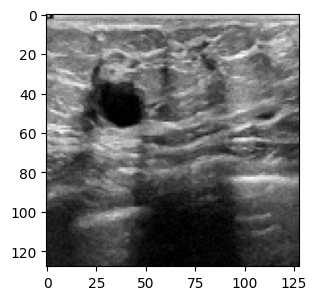

In [18]:
# Predict classes of the test images
predicted_classes = model.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predicted_classes, axis=1)
actual_labels = np.argmax(test_labels, axis=1)
label_names = {0: 'Normal', 1: 'Malignant', 2: 'Benign'}

import matplotlib.pyplot as plt

# Ensure that labels are in the correct shape
actual_labels = np.argmax(test_labels, axis=1).flatten()  # Flatten in case it's 2D
predicted_labels = np.argmax(predicted_classes, axis=1).flatten()  # Flatten in case it's 2D

# Number of images to display
n_images = 10

plt.figure(figsize=(15, 15))
for i in range(n_images):
    plt.subplot(3, n_images // 3 + 1, i + 1)
    plt.imshow(test_images[i])
    
    # Ensure that the label used for indexing is a scalar
    actual_label = label_names[int(actual_labels[i])]
    predicted_label = label_names[int(predicted_labels[i])]
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 195ms/step


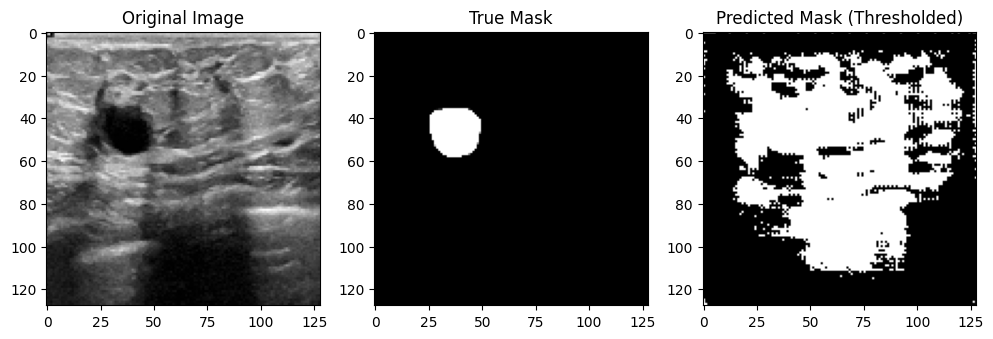

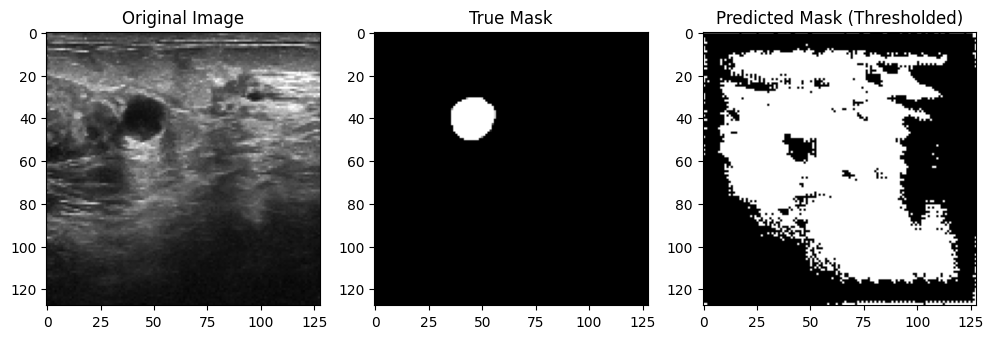

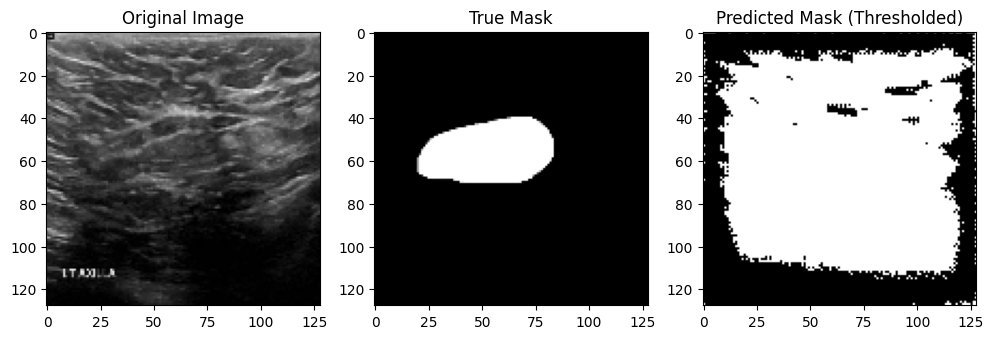

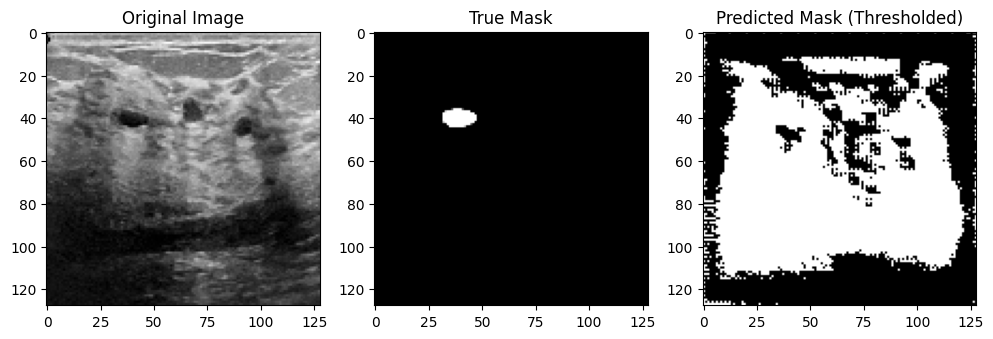

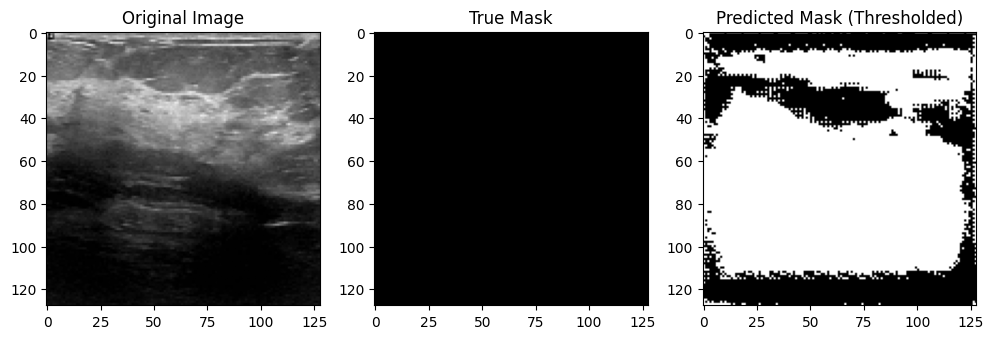

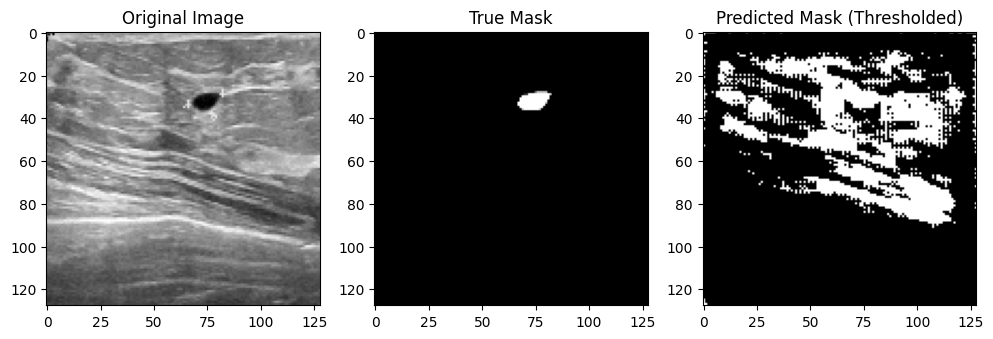

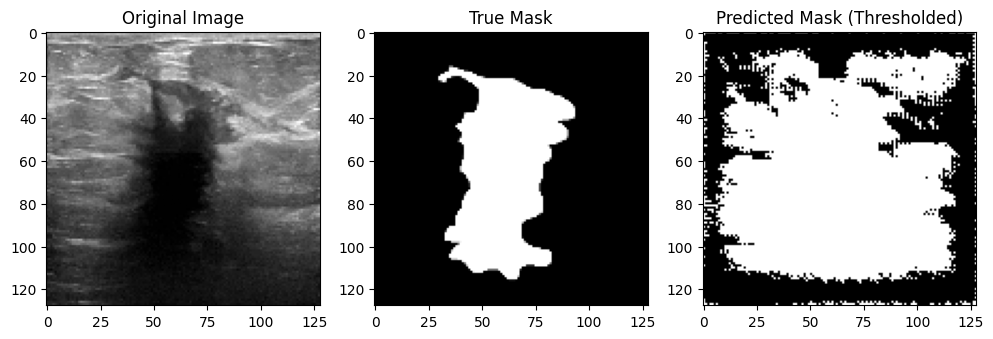

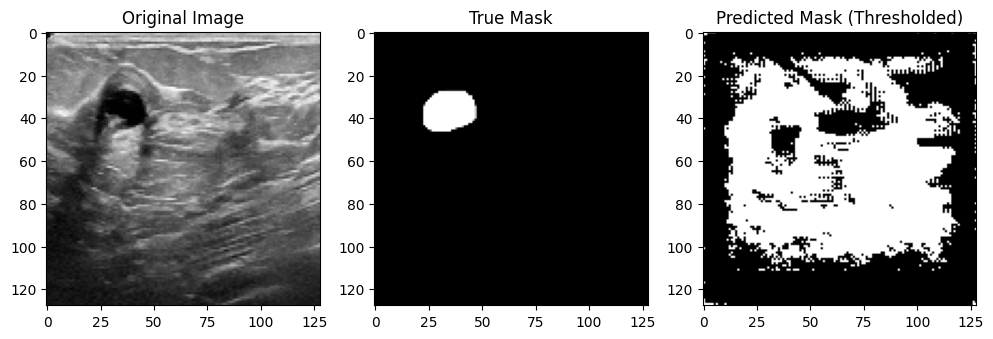

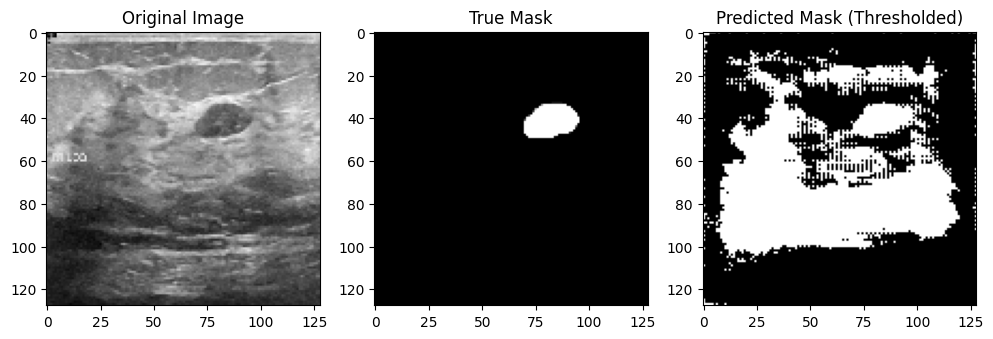

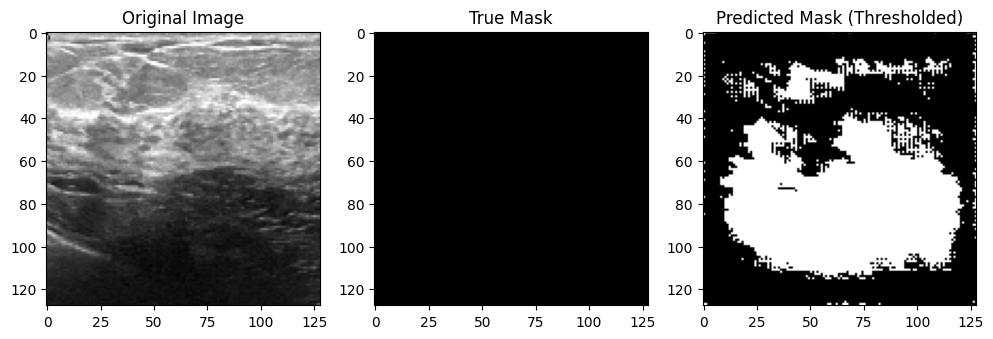

In [14]:
import matplotlib.pyplot as plt

# Predict masks for some test images
n_samples = 10
sample_images = test_images[:n_samples]
predicted_masks = model.predict(sample_images)

# Apply threshold
threshold = 0.1  # 65%
predicted_masks_thresholded = (predicted_masks > threshold).astype(int)

# Plot the results with thresholding
for i in range(n_samples):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks_thresholded[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask (Thresholded)')

    plt.show()
